In [ ]:
%run config.py
from qtnm_fields import BathTubField
from scipy.constants import c, electron_mass as me, elementary_charge as qe, mu_0 as mu0
from trace import electron_trace_relativistic
import concurrent.futures
from functools import partial
import pickle

# Updates on Simulation/Software Plans

## 24/06/21

## Example Magnetic Trap Configuration:

 - Trap formed by two coils of wire, radius 3cm, positioned at $z = \pm 25cm$.
 - Current in the coils set such that the maximum field will trap electrons with $\theta \ge 86^\circ$, according to:
 
\begin{equation*}
\theta \ge \sin^{-1}\left(\sqrt{1 - \frac{\Delta B}{B_0}}\right)
\end{equation*}

 - This gives $\Delta B \approx 4.86mT$.
 - Coils surrounded by a larger solenoid, which provides a 1T background field.
 - Equivalent to a scaled up version of Project 8's "bathtub trap".
 - Assume an 18.6 KeV electron. Vary starting position and angle.

## Note that the small gyroradius means that the radial confinement of the trap is unimportant. For example, initialising an electron in the middle of the trap, with $\theta = 89^\circ$:

In [ ]:
# Some helper functions
def current_from_b(b):
    return 2.0 * r_coil * b / mu0

def on_axis_field(z, current):
    return mu0 * current * r_coil**2 / (2.0 * (r_coil**2 + z**2)**(1.5))

def zfromb(b, current):
    tmp = (mu0 * r_coil**2 * current / 2.0 / b)**(2.0/3.0)
    if tmp < r_coil**2:
        return 0.0
    return np.sqrt(tmp - r_coil**2)

In [ ]:
# Initial kinetic energy (eV)
T = 18600
# Rel. gamma
gamma_rel = T * qe / (me*c**2) + 1
# (v/c)^2
beta_sq = 1 - 1 / gamma_rel**2
# Initial electron speed
v0 = np.sqrt(beta_sq) * c
# Background B-field (T)
B0 = np.array([0, 0, 1.0])

# Distance between coils
coil_distance = 0.5
# Coil radius
r_coil = 0.03

In [ ]:
# Require an 86 degree limit, assuming a mid-point field of 1T
deltaB = np.cos(np.deg2rad(86))**2
print('Delta B = %.4f' % deltaB)

# Calculate current such that peak B = 4mT
current = 2.0 * deltaB * r_coil / mu0
print('Total current = %.4f' % current)

# Set up a QTNM like field, with coils at +/- 3cm
zc1 = -0.5*coil_distance
zc2 = 0.5*coil_distance
qtnm_bottle = BathTubField(radius=r_coil, current=current, Z1 = zc1, Z2 = zc2, background=B0)
print('Max field perturbation = %.4E' % (qtnm_bottle.evaluate_field(0,0,zc1)[2] - 1))

In [ ]:
trace_theta = partial(electron_trace_relativistic, r0=0, B0=B0, v0=v0, bfield=qtnm_bottle, nrot=1e4)
res = trace_theta(-np.deg2rad(1.0))
    
Ny = 51
Nz = 101
# Calculate field on 2D slice
ygrid = np.linspace(-0.05,0.05,Ny)
zgrid = np.linspace(1.1*zc1,1.1*zc2,Nz)

Y, Z = np.meshgrid(ygrid, zgrid)

bx = np.zeros_like(Y)
by = np.zeros_like(Y)
bz = np.zeros_like(Y)

# For plotting purposes subtract background back off
for i in range(Nz):
    for j in range(Ny):
        x = 0.0
        y = ygrid[j]
        z = zgrid[i]
        
        bx[i,j], by[i,j], bz[i,j] = qtnm_bottle.evaluate_field(x, y, z) - B0
            
x = res.y[0]
y = res.y[1]
z = res.y[2]
incr = 10 # Plot every 10th point of trace

plt.streamplot(Y, Z, by, bz, color="blue", linewidth=0.1, density=2)
plt.plot(-r_coil,zc1, markersize=3, marker='o', color='orange', alpha=0.75)
plt.plot(r_coil,zc1, markersize=3, marker='o', color='orange', alpha=0.75)
plt.plot(-r_coil,zc2, markersize=3, marker='o', color='orange', alpha=0.75)
plt.plot(r_coil,zc2, markersize=3, marker='o', color='orange', alpha=0.75)
ax = plt.gca()

xtrace = x[::incr]
ztrace = z[::incr]
plt.plot(xtrace, ztrace, alpha = 0.25, color='red')

plt.xlim(ygrid[0], ygrid[-1])
plt.ylim(zgrid[0], zgrid[-1])
plt.xlabel(r'$z(m)$')
plt.ylabel(r'$y(m)$')
plt.title(r'Electron Position for $\theta = 89^\circ$', fontsize=14)
plt.tight_layout()

## We can now examine multiple angles, and test against the trapping criteria equation

In [ ]:
with open('resultsr0.pkl', 'rb') as f:
    resultsr0 = pickle.load(f)
with open('resultsr1.pkl', 'rb') as f:
    resultsr1 = pickle.load(f)
with open('resultsr3.pkl', 'rb') as f:
    resultsr3 = pickle.load(f)

In [ ]:
zmaxr0 = []
for r in resultsr0:
    zmaxr0.append(np.min(r.y[2]))

In [ ]:
theta_deg = np.arange(0,5,0.1)
theta = np.deg2rad(-theta_deg)

In [ ]:
b_initial = qtnm_bottle.evaluate_field(0,0,0)[2]
zmax_clipr0 = np.array(zmaxr0).clip(min=-0.25)
b_turning_numericalr0 = []
for z in zmax_clipr0:
    b_turning_numericalr0.append(qtnm_bottle.evaluate_field(0,0,np.min(z))[2])
b_turning_numericalr0 = np.array(b_turning_numericalr0)

b_turning_theory = []
for t in theta:
    cos2 = np.sin(t)**2
    b_turning_theory.append((1.0 + cos2) * b_initial)
b_turning_theory = np.array(b_turning_theory)

In [ ]:
theta_mod = 90 - theta_deg
fig, ax = plt.subplots(1,2, figsize=[12,6])
ax[0].plot(theta_mod, zmaxr0)
ax[0].set_ylim(-0.3, 0.025)
ax[0].set_xlim(90,85)
ax[0].set_xlabel(r'$\theta \mathrm{(deg.)}$')
ax[0].set_ylabel(r'$\mathrm{Max.\; Displ.\;(m)}$')
ax[0].axhline(-0.25, color='black', linestyle='--')
ax[0].axvline(86.0, color='black', linestyle='--')
plt.suptitle(r'$\mathrm{R_{coil} = 3cm,\;B_{coil} = 4.9mT,\;L_{Solen.} = 50cm}$')
ax[1].plot(theta_mod, b_turning_numericalr0, label='Numerical')
ax[1].plot(theta_mod, b_turning_theory, label='Theory', linestyle='--')
ax[1].set_xlabel(r'$\theta \mathrm{(deg.)}$')
ax[1].set_ylabel(r'$\mathrm{Max.\; B.\;(T)}$')
ax[1].set_xlim(90,85)
plt.legend()
plt.tight_layout()

## Works well on axis (as it should). What sort of magnetic field is experienced by the electron?

In [ ]:
b_rms = []
# Loop over results
for ir, r in enumerate(resultsr0):
    bmag2_tot = 0.0
    # Only want to record up to turning point
    for i in np.arange(len(r.t)):
        bmag2_tot += qtnm_bottle.evaluate_field_magnitude(r.y[0][i],r.y[1][i],r.y[2][i])**2
        if r.y[2][i] < -0.25 or r.y[5][i] > 0:
            print(ir, i, r.y[2][i], r.y[5][i])
            b_rms.append(np.sqrt(bmag2_tot / (i + 1)))
            break
        if i == len(r.t) - 1:
            print(ir, i, r.y[2][i], r.y[5][i], 'reached end!')
            b_rms.append(np.sqrt(bmag2_tot / len(r.t))) 

In [ ]:
plt.plot(theta_mod, np.array(b_rms) - 1)
plt.ylim(bottom=0)
plt.yscale('log')
plt.ylim(1e-5,2e-3)
plt.xlim(90,85)
plt.title('RMS Magnetic field along Electron Path')
plt.ylabel(r'$\sqrt{\widebar{B^2}} - 1$')
plt.xlabel(r'$\theta \mathrm{(deg.)}$')
plt.tight_layout()

## So for $\sim$ on axis electrons we expect a variation of $\sim 10^{-4} - 10^{-3}$, for this design.

## Can also try different starting positions, for example $r_0 = 1cm$:

In [ ]:
b_rmsr1 = []
# Loop over results
for ir, r in enumerate(resultsr1):
    bmag2_tot = 0.0
    # Only want to record up to turning point
    for i in np.arange(len(r.t)):
        bmag2_tot += qtnm_bottle.evaluate_field_magnitude(r.y[0][i],r.y[1][i],r.y[2][i])**2
        if r.y[2][i] < -0.25 or r.y[5][i] > 0:
            print(ir, i, r.y[2][i], r.y[5][i])
            b_rmsr1.append(np.sqrt(bmag2_tot / (i + 1)))
            break
        if i == len(r.t) - 1:
            print(ir, i, r.y[2][i], r.y[5][i], 'reached end!')
            b_rmsr1.append(np.sqrt(bmag2_tot / len(r.t))) 

In [ ]:
plt.plot(theta_mod, np.array(b_rms) - 1, label=r'$r=0cm$')
plt.plot(theta_mod, np.array(b_rmsr1) - 1, linestyle='--', label=r'$r=1cm$')
plt.ylim(bottom=0)
plt.yscale('log')
plt.ylim(1e-5,2e-3)
plt.xlim(90,85)
plt.title('RMS Magnetic field along Electron Path')
plt.ylabel(r'$\sqrt{\widebar{B^2}} - 1$')
plt.xlabel(r'$\theta \mathrm{(deg.)}$')
plt.legend()
plt.tight_layout()

In [ ]:
b_rmsr3 = []
# Loop over results
for ir, r in enumerate(resultsr3):
    bmag2_tot = 0.0
    # Only want to record up to turning point
    for i in np.arange(len(r.t)):
        bmag2_tot += qtnm_bottle.evaluate_field_magnitude(r.y[0][i],r.y[1][i],r.y[2][i])**2
        if r.y[2][i] < -0.25 or r.y[5][i] > 0:
            print(ir, i, r.y[2][i], r.y[5][i])
            b_rmsr3.append(np.sqrt(bmag2_tot / (i + 1)))
            break
        if i == len(r.t) - 1:
            print(ir, i, r.y[2][i], r.y[5][i], 'reached end!')
            b_rmsr3.append(np.sqrt(bmag2_tot / len(r.t))) 

In [ ]:
plt.plot(theta_mod, np.array(b_rms) - 1, label=r'$r=0cm$')
plt.plot(theta_mod, np.array(b_rmsr1) - 1, linestyle='--', label=r'$r=1cm$')
plt.plot(theta_mod, np.array(b_rmsr3) - 1, linestyle='--', label=r'$r=3cm$')
plt.ylim(bottom=0)
plt.yscale('log')
plt.ylim(1e-5,2e-3)
plt.xlim(90,85)
plt.title('RMS Magnetic field along Electron Path')
plt.ylabel(r'$\sqrt{\widebar{B^2}} - 1$')
plt.xlabel(r'$\theta \mathrm{(deg.)}$')
plt.legend()
plt.tight_layout()

## Re-examine Trapping:

In [ ]:
zmaxr1 = []
for r in resultsr1:
    zmaxr1.append(np.min(r.y[2]))

zmax_clipr1 = np.array(zmaxr1).clip(min=-0.25)
    
b_turning_numericalr1 = []
for z in zmax_clipr1:
    b_turning_numericalr1.append(qtnm_bottle.evaluate_field(0,0,np.min(z))[2])
b_turning_numericalr1 = np.array(b_turning_numericalr1)

In [ ]:
zmaxr3 = []
for r in resultsr3:
    zmaxr3.append(np.min(r.y[2]))

zmax_clipr3 = np.array(zmaxr3).clip(min=-0.25)
    
b_turning_numericalr3 = []
for z in zmax_clipr3:
    b_turning_numericalr3.append(qtnm_bottle.evaluate_field(0,0,np.min(z))[2])
b_turning_numericalr3 = np.array(b_turning_numericalr3)

In [ ]:
theta_mod = 90 - theta_deg
fig, ax = plt.subplots(1,2, figsize=[12,6])
ax[0].plot(theta_mod, zmaxr0, label=r'$r=0cm$')
ax[0].plot(theta_mod, zmaxr1, linestyle='--', label=r'$r=1cm$')
ax[0].plot(theta_mod[:25], zmaxr3[:25], linestyle='--', label=r'$r=3cm$')
ax[0].legend(loc='upper right')
ax[0].set_ylim(-0.3, 0.025)
ax[0].set_xlim(90,85)
ax[0].set_xlabel(r'$\theta \mathrm{(deg.)}$')
ax[0].set_ylabel(r'$\mathrm{Max.\; Displ.\;(m)}$')
ax[0].axhline(-0.25, color='black', linestyle='--')
ax[0].axvline(86.0, color='black', linestyle='--')
plt.suptitle(r'$\mathrm{R_{coil} = 3cm,\;B_{coil} = 4.9mT,\;L_{Solen.} = 50cm}$')
ax[1].plot(theta_mod, b_turning_numericalr0, label='Numerical (r=0)')
ax[1].plot(theta_mod, b_turning_numericalr1, label='Numerical (r=1)')
ax[1].plot(theta_mod, b_turning_numericalr3, label='Numerical (r=3)')
ax[1].plot(theta_mod, b_turning_theory, label='Theory', linestyle='--')
ax[1].set_xlabel(r'$\theta \mathrm{(deg.)}$')
ax[1].set_ylabel(r'$\mathrm{Max.\; B.\;(T)}$')
ax[1].set_xlim(90,85)
plt.legend()
plt.tight_layout()

# Current/Future Plans:

 - Use COMSOL for trapping analysis. Number of advantages:
  - Quicker
  - Better 3D visualisation
  - Consistent calculation of solenoid field
  - ...
 - Starting a comparison of COMSOL and python results (Daniel & Seb)
 - Already have an initial trap configuration in COMSOL

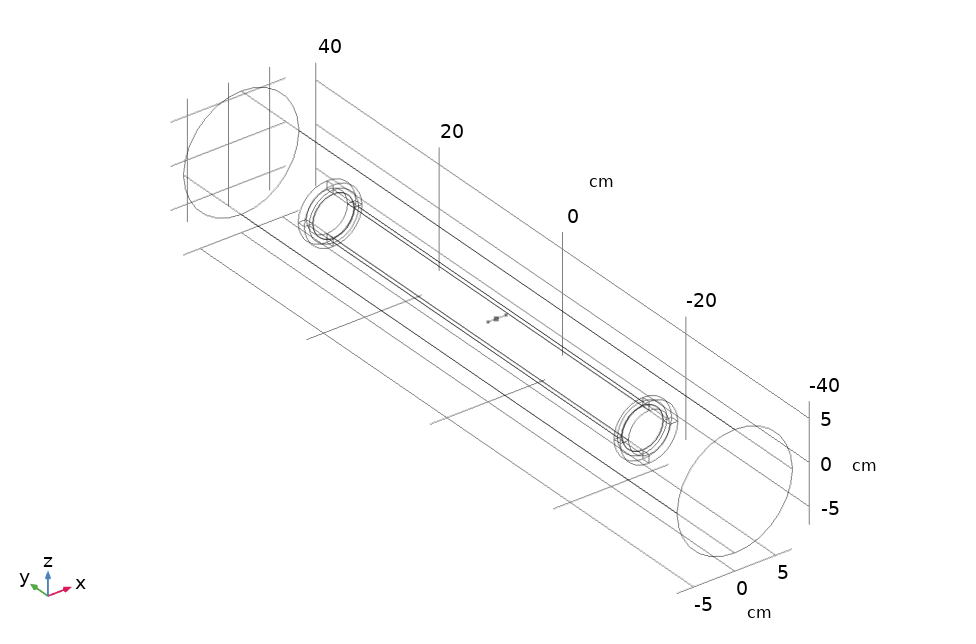

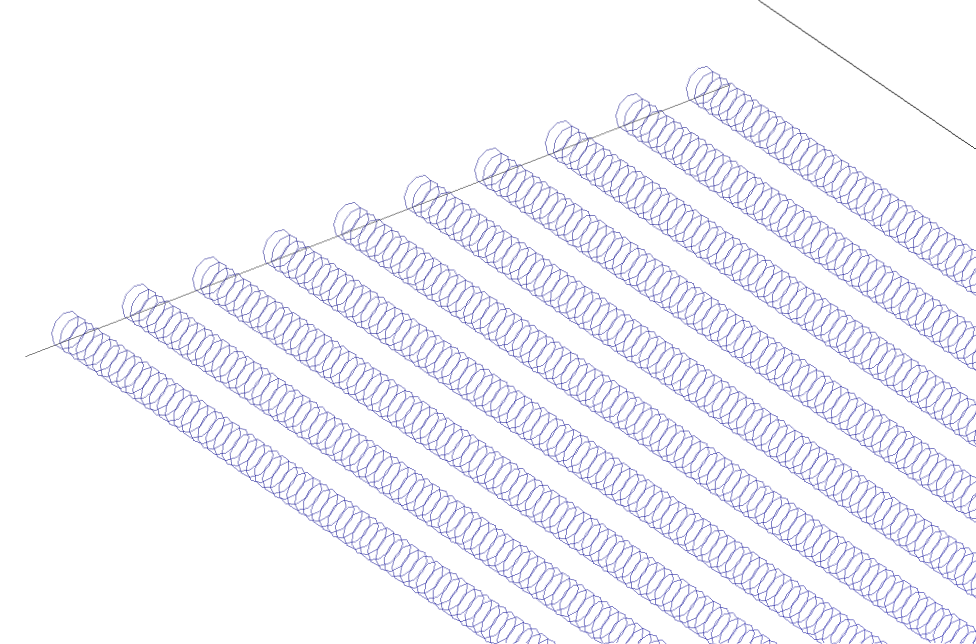

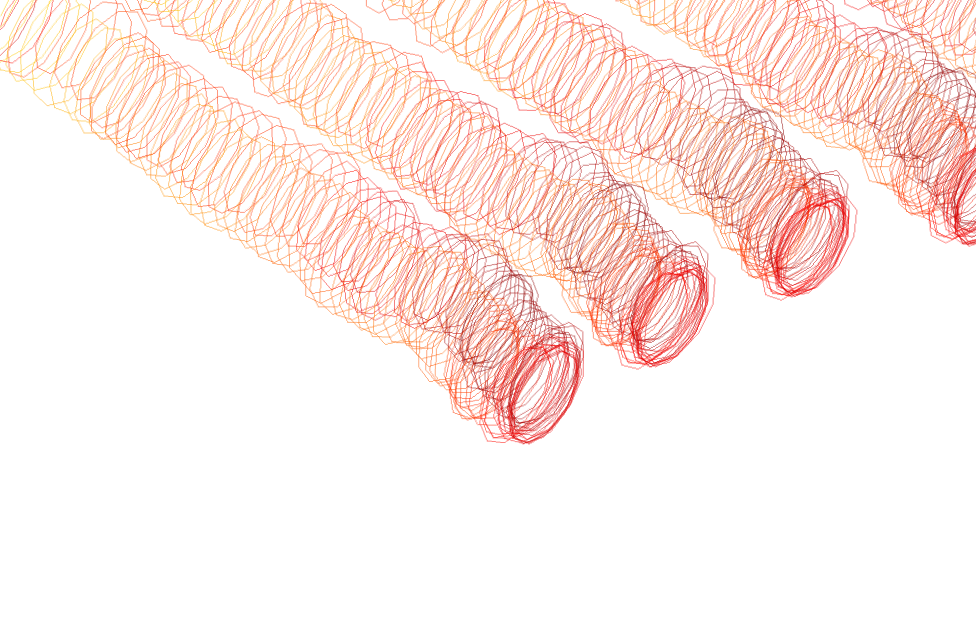

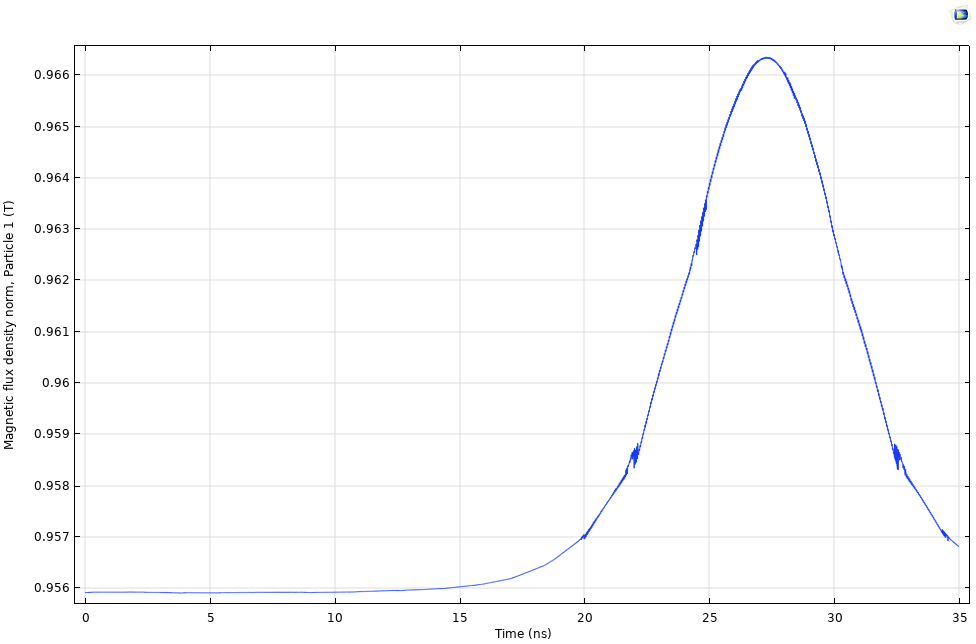